In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from lxml import etree

import time

import pickle

# My code
import data.preprocessing as preproc
import project_fxns.combine_by_mz as combine_mz

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ppm = 30

# Get hmdb data
local = '/home/ubuntu/users/isaac/projects/'
path = '/revo_healthcare/data/raw/HMDB/'
f_name = 'hmdb_serum_metabolite_db_20170813.xml'
xml_file = local+path+f_name

pickle_path = local + path + 'hmdb_serumdb_20170813_dict.p'

### TODO: make all this so that it checks if these files are present - Claire sent an email about a fxn that helps do this in the past

In [11]:
# namespace - at the top of file. fucks with every tag.
# very annoying, so name all tags ns + tag
ns = '{http://www.hmdb.ca}'
nsmap = {None : ns}
# If you're within a metabolite tag
count = 0
seen_mass = 0
d = {}
for event, element in etree.iterparse(xml_file, tag=ns+'metabolite'):
    tree = etree.ElementTree(element)
    # Aggregate info into a dictionary of 
    # {HMDB_ID: iso_mass}
    accession = []
    # Get accession number and masses for each metabolite
    # Could be multiple accessions. Grab all of them, 
    # sort to make unique identifier
    for elem in tree.iter():
        if elem.tag == ns+'accession':
            accession.append(elem.text)
        # If you just saw a 'mono_mass' entry,
        # get the mass value and reset, saying you
        # havent seen 'mono_mass' in the text of next metabolite
        if (elem.tag == ns+'value') & (seen_mass == 1): 
                mass = float(elem.text)
                seen_mass = 0
        if elem.text == 'mono_mass':
                seen_mass = 1
    elem.clear()
    
    # sort accession numbers and join with '_'    
    accession_key = '_'.join(sorted(accession))
    # add to dictionary
    if mass:
        d[accession_key] = mass
        
    # reset mass - only add feature if mass listed
    mass = None
    # reset accession numbers
    accession = []

    element.clear()
    count += 1
    if count % 1000 == 0:
        print('Made it through ' + str(count) + ' metabolites')

#pickle.dump(d, open('serumdb_dict.p', 'wb'))
print 'Number of metabolites: %s' % len(d.keys())

Made it through 1000 metabolites
Made it through 2000 metabolites
Made it through 3000 metabolites
Made it through 4000 metabolites
Made it through 5000 metabolites
Made it through 6000 metabolites
Made it through 7000 metabolites
Made it through 8000 metabolites
Made it through 9000 metabolites
Made it through 10000 metabolites
Made it through 11000 metabolites
Made it through 12000 metabolites
Made it through 13000 metabolites
Made it through 14000 metabolites
Made it through 15000 metabolites
Made it through 16000 metabolites
Made it through 17000 metabolites
Made it through 18000 metabolites
Made it through 19000 metabolites
Made it through 20000 metabolites
Made it through 21000 metabolites
Made it through 22000 metabolites
Made it through 23000 metabolites
Made it through 24000 metabolites
Made it through 25000 metabolites
Number of metabolites: 25310


In [16]:
# write to file
pickle.dump(d, open(pickle_path, 'wb'))

In [3]:
hmdb_dict = pickle.load(open(pickle_path, 'rb'))

In [5]:
# masses are entries of dict, yes?
hmdb_masses = pd.Series(hmdb_dict, dtype='float32')

In [11]:
hmdb_masses[0:5]

HMDB0000001_HMDB00001_HMDB04935_HMDB06703_HMDB06704    169.085129
HMDB00002                                               74.084396
HMDB00005_HMDB06544                                    102.031693
HMDB00008                                              104.047340
HMDB00010_HMDB04990_HMDB04991                          300.172546
dtype: float32

In [12]:
ppm_matrix = combine_mz.ppm_matrix(hmdb_masses, hmdb_masses)

In [3]:
# write to file
np_path = local+path+'/hmdb_serumdb_20170813_ppm_matrix.npy'
np.save(np_path, ppm_matrix)

NameError: name 'ppm_matrix' is not defined

In [4]:
# reload it
ppm_matrix = np.load(np_path)

In [6]:
# Convert to upper triangular matrix
idx_ppm = np.tril_indices(ppm_matrix.shape[0])
ppm_matrix[idx_ppm] = np.nan

In [4]:
# get indices whose ppm falls below cutoff
# Ignore runtime warning - means we're ignoring NaN values
isomer_indices = np.argwhere(ppm_matrix < ppm)
isomer_indices.shape
print isomer_indices[0:10]

NameError: name 'ppm_matrix' is not defined

In [20]:
# write isomer indices to file
np.save(local+path+'/hmdb_serumdb_20170813_isomer_indices_%s_ppm.npy' % ppm, isomer_indices)

In [8]:
isomer_indices = np.load(local+path+'/hmdb_serumdb_20170813_isomer_indices_%s_ppm.npy' % ppm)


In [132]:
# This is super fucking slow

def group_isomer_indices(indices):
    '''
    GOAL:
        Given a list of isomer pairs, combine all isomers pairs into 
        a single group - i.e. [[0,1], [1,5], [2,3]] becomes [[0,1,5], [2,3]]
    INPUT:
        numpy array (nx2) of index pairs from a square difference-matrix
        (same mz's used)
    OUTPUT: list of numpy arrays containing the indices of mz-matching
        features
    BUGS:
        Known bug means that if features 
        # A&B < 30 ppm
        #  B&C < 30 ppm, 
        # But A&C = 50 ppm,
        # A,B,C will still be grouped together
    '''
    output = []
    t1 = time.time()
    for enum, idx in enumerate(indices):
        if enum % 2 == 0:
            print '%s percent finished: on %s of %s' % (float(enum) / len(indices),
                                                  enum, len(indices))
            print 'it took {time} sec'.format(time=time.time() - t1)
            t1 = time.time()
        #print '\n\nfinding indices that match ', idx
        
        # Find any matches to the current index in the list of indices
        match_idx = np.argwhere([np.in1d(idx, poop).any() for poop in indices])
        #print 'Indices that match\n', match_idx
        #print 'Do these match %s?: \n %s' % (idx, indices[match_idx])
        unique_matches = np.unique(indices[match_idx])
        #print 'Unique matches', unique_matches
        
        # Check if any values from unique_matches are present in output
        # if not, append
        # if so, append to place where they're found
        in_output = [np.in1d(unique_matches, poop).any() for poop in output]
        #print 'Output\n', output
        #print 'Is it in the output?\n', in_output
        where_in_output = np.argwhere(in_output)
        #print 'Where?\n', where_in_output, 'Size', where_in_output.size, 'Greater than 1?', where_in_output.size
        
        
        # if found in output, append it to where you found it in the output
        if  where_in_output.size != 0:
            if where_in_output.size > 1:
                raise ValueError(('You should only find an index one place in' +
                                  'the output. Something is wrong'))
            #print 'Append unique vals to entry that overlaps in output'
            #print int(where_in_output)
            #print output[int(where_in_output)]
            
            # append new indices to thos already in output
            output[int(where_in_output)] = np.append(output[int(where_in_output)],
                                                     unique_matches)
        # If not found in an entry of the output, append values found to the output 
        else:
            output.append(unique_matches)
        #print 'Output', output
        #
    # Eliminate repeat values
    output = [np.unique(poop) for poop in output]
    #print ('-'*50, 'Final output\n', output)
    return output


test = np.array([[0,1], [2,3], [0,4], [4,5], [1,6]])

iso = group_isomer_indices(test)
print test
print iso

0.0 percent finished: on 0 of 5
it took 0.000571966171265 sec
0.4 percent finished: on 2 of 5
it took 0.000887155532837 sec
0.8 percent finished: on 4 of 5
it took 0.000928163528442 sec
[[0 1]
 [2 3]
 [0 4]
 [4 5]
 [1 6]]
[array([0, 1, 4, 5, 6]), array([2, 3])]


In [133]:
# group indices that are found together
# TODO: Known bug means that if features 
# A&B < 30 ppm
#  B&C < 30 ppm, 
# But A&C = 50 ppm,
# A,B,C will still be grouped together
print isomer_indices.shape
isomers_groupped = group_isomer_indices(isomer_indices)

(6329396, 2)
0.0 percent finished: on 0 of 6329396
it took 0.000218868255615 sec


KeyboardInterrupt: 

In [5]:
# TODO - fix this - it takes too long
# 7 seconds for 25,000 molecules ends up being
# 48 hours of run-time

def isomers_from_ppm_matrix(ppm_matrix, ppm):
    bool_idx = ppm_matrix < ppm
    #print '\nGreater than ppm?:\n', bool_idx
    
    # Get indices where isomer
    iso_idx = np.argwhere(bool_idx)
    #print iso_idx
    
    collect = []
    # Get isomers from every entry
    t1 = time.time()
    for idx in range(0, ppm_matrix.shape[0]):
        if idx % 2 == 0:
            print 'Finished {perc}, working on {num} of {total}'.format(
                perc= float(idx) / ppm_matrix.shape[0], num=idx,
                total=ppm_matrix.shape[0])
            print 'Took {time} sec'.format(time=time.time() - t1)
            t1 = time.time()
        idx_one_feature = [i[0] == idx for i in iso_idx]
        isomers_one_feature = np.unique(iso_idx[idx_one_feature,:])
        
        ### add to output if not already present in collect
        
        # If single entry
        #if type(isomers_one_feature) == bool
        print isomers_one_feature
        present = any(
                        (isomers_one_feature == i).all() for i in collect
                      )
        #print present
        if not present:
            collect.append(isomers_one_feature)
        #print collect
        
    return collect

toy_ppm = np.array([[0, 100, 15],
                    [100, 0, 90 ],
                    [15, 90, 0]]
                  ) # not additive ppms
print 'Input:\n', toy_ppm
isomers_from_ppm_matrix(toy_ppm, 30)

Input:
[[  0 100  15]
 [100   0  90]
 [ 15  90   0]]
Finished 0.0, working on 0 of 3
Took 0.000194072723389 sec
[0 2]
[1]
Finished 0.666666666667, working on 2 of 3
Took 0.000854015350342 sec
[0 2]


[array([0, 2]), array([1])]

In [12]:
# This will take forever. Be less stupid,
# you piece of garbage there's also a bug. fuck you.
ppm = 30
isomers_30ppm = isomers_from_ppm_matrix(ppm_matrix, ppm)

Finished 0.0, working on 0 of 25310
Took 0.000824213027954 sec
[  0 254]
[   1 2841]
Finished 7.90201501383e-05, working on 2 of 25310
Took 20.5362949371 sec
[ 2 39]
[  3   5  15 204 211 240 378 388]


/home/ubuntu/anaconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


AttributeError: 'bool' object has no attribute 'all'

In [71]:
# TODO - fix this - it takes too long
# 7 seconds for 25,000 molecules ends up being
# 48 hours of run-time

def isomers_from_ppm_matrix(ppm_matrix, ppm):
    '''
    Only tested on square matrices for now
    INPUT - numpy array of ppm values
    OUTPUT - list of arrays - position in list is
        same as row in matrix, values in each list-entry are
        indices along column of array
    '''
    bool_idx = ppm_matrix < ppm
    # Get indices where you have an isomer
    # for each row
    iso_indices = [np.argwhere(x) for x in bool_idx]
    return iso_indices
    
        

toy_ppm = np.array([
    [0, 20, 15, 50],
    [100, 0, 90, 10 ],
    [15, 90, 0, 10]],
                  ) # not additive ppms
print 'Input:\n', toy_ppm
isomers_from_ppm_matrix(toy_ppm, 30)

Input:
[[  0  20  15  50]
 [100   0  90  10]
 [ 15  90   0  10]]


[array([[0],
        [1],
        [2]]), array([[1],
        [3]]), array([[0],
        [2],
        [3]])]

In [74]:
ppm = 30
isomers = isomers_from_ppm_matrix(ppm_matrix, ppm)
np.save(local+path+'isomer_index_per_feature.npy', isomers)

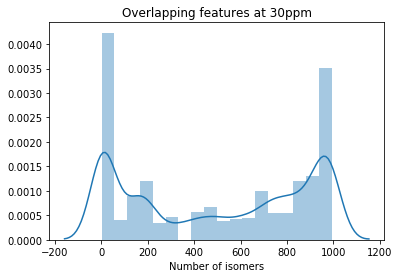

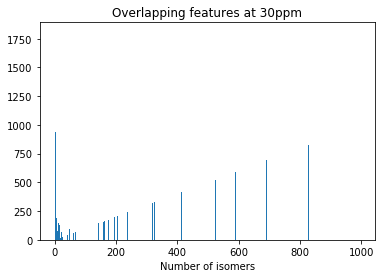

In [86]:
num_isomers = [len(x) for x in isomers]
sns.distplot(num_isomers,)
plt.title('Overlapping features at 30ppm')
plt.xlabel('Number of isomers')
plt.show()

plt.hist(num_isomers, bins=1000)
plt.xlabel('Number of isomers')
plt.title('Overlapping features at 30ppm')
plt.show()

In [105]:
single_isomers = sum([i <= 1 for i in num_isomers])
print ("Number of metabolites from HMDB with no " +
       'isomers: {num} out of {hmdb}: {per:.2f} percent'.format(
       num=single_isomers, hmdb=ppm_matrix.shape[0],
           per = float(single_isomers) / ppm_matrix.shape[0]*100))

Number of metabolites from HMDB with no isomers: 2273 out of 25310: 8.98 percent


## Repeat at 5ppm

In [87]:
ppm = 3
isomers = isomers_from_ppm_matrix(ppm_matrix, ppm)
np.save(local+path+'isomer_index_per_feature_%s_ppm.npy' % ppm,
        isomers)

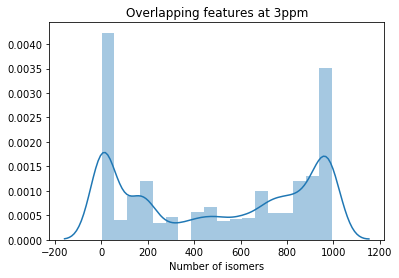

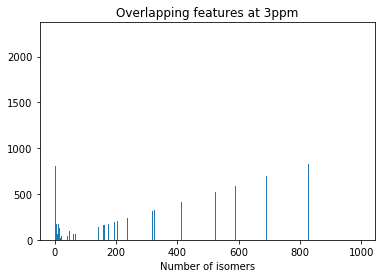

In [89]:
num_isomers = [len(x) for x in isomers]
sns.distplot(num_isomers,)
plt.title('Overlapping features at %sppm' % ppm)
plt.xlabel('Number of isomers')
plt.show()

plt.hist(num_isomers, bins=1000)
plt.xlabel('Number of isomers')
plt.title('Overlapping features at %sppm' % ppm)
plt.show()

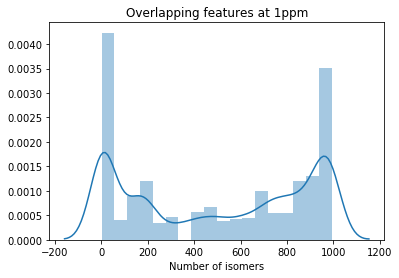

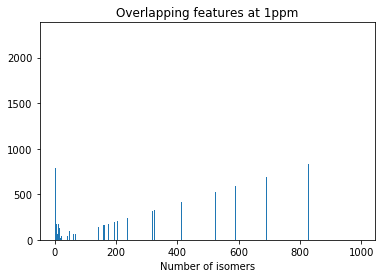

In [90]:
ppm = 1
isomers = isomers_from_ppm_matrix(ppm_matrix, ppm)
np.save(local+path+'isomer_index_per_feature_%s_ppm.npy' % ppm,
        isomers)

num_isomers = [len(x) for x in isomers]
sns.distplot(num_isomers,)
plt.title('Overlapping features at %sppm' % ppm)
plt.xlabel('Number of isomers')
plt.show()

plt.hist(num_isomers, bins=1000)
plt.xlabel('Number of isomers')
plt.title('Overlapping features at %sppm' % ppm)
plt.show()